## 이 노드의 루브릭       

1. SRGAN을 통해 고해상도의 이미지를 생성하였다.(SRGAN을 통해 생성된 이미지를 제출하였다.)
2. 다양한 해상도의 이미지에 대해 시각화를 통해 원본, SRGAN생성본, interpolation 생성본을 비교 분석하였다.  
(이미지의 특성과 Super Resolution 방법을 관련지어 생성 결과를 체계적으로 분석하였다.)
3. 저해상도 gif 동영상을 고해상도 영상으로 성공적으로 변환하였다.   
(저해상도 원본 gif와 생성된 고해상도 gif의 해상도 차이가 시각적으로 확인 가능하다.)

## 목차           

#### 1. 직접 고른 이미지로 SRGAN 실험하기(원래 고해상도)    
- 1. Div2K의 이미지와 유사한 이미지를 골라 로드한다.
- 2. Bicubic interpolation을 적용해 가로*세로 픽셀 수를 $1/4$ 로 줄인다.    
- 3. 2에서 줄인 이미지를 SRGAN에 투입하여 고해상도 이미지를 생성한다. def apply_srgan이용   
- 4. 2의 이미지에 다시 interpolation을 적용하여 가로*세로 픽셀 수를 4배로 늘린다. intepolation
- 5. 3개 이미지(4(bicubic),3(SRGan),1(원본 이미지)를 나란히 시각화한다.(제목에 라벨링)    
- 6. 이 때, Super Resolution을 했을 때 어떤 결과가 나왔으며, 왜 그런 것 같은지를 설명한다.

---
#### 2. 직접 고른 이미지로 SRGAN 실험하기(원래 저해상도)
- 1. Div2K의 이미지와 유사한 __저해상도__ 이미지를 골라 로드한다.
- 2. SRGAN에 투입하여 고해상도 이미지를 생성한다. def apply_srgan이용   
- 3. 2의 이미지에 다시 interpolation을 적용하여 가로*세로 픽셀 수를 4배로 늘린다. intepolation
- 4. 2개 이미지(3(bicubic),2(SRGan))를 나란히 시각화한다.(제목에 라벨링)    
- 5. 이 때, Super Resolution을 했을 때 어떤 결과가 나왔으며, 왜 그런 것 같은지를 설명한다.      

---
#### 3. SRGAN을 이용해 고해상도 gif 생성하기      
- 한 프레임씩 고해상도 이미지로 변환시켜 모든 프레임에 적용하고, 그 프레임을 합쳐 동영상으로 만들어본다.

1. gif 파일 불러오기       
2. 프레임별 Super Resolution 적용하기      
3. 프레임을 합쳐 gif 만들기  
4. jupyter notebook에 gif 표시하기

## 1. 직접 고른 이미지로 SRGAN 실험하기     

### 1. Div2K의 이미지와 유사한 이미지를 골라 로드한다.        

- 풍경이나 사물을 주제로 한 고화질 이미지를 찾아 로드한다.

이미지의 크기 :  (512, 384)


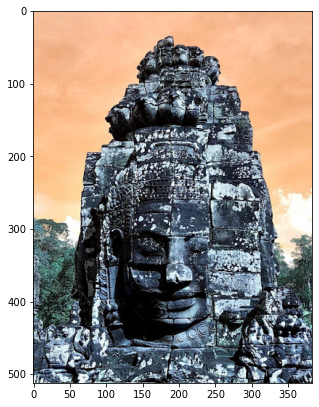

In [25]:
import os

import cv2
import matplotlib.pyplot as plt

image_file = os.getenv('HOME')+'/SUBMIT_MISSION_GIT/ex16_SRCNN/Image/ancor.jpg'

origin = cv2.imread(image_file)
origin_shape = origin.shape[:2]

print('이미지의 크기 : ', origin_shape)

plt.figure(figsize=(5,8))
plt.imshow(origin)

### 2. bicubic을 이용해 고화질 이미지의 가로*세로 픽셀수를 $1/4$로 줄인다.

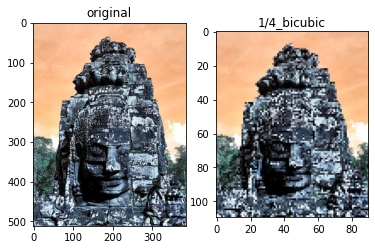

In [27]:
#원래 가로/세로 픽셀은 384*521이므로
bicubic_origin = cv2.resize(origin, dsize=(90,110), interpolation=cv2.INTER_CUBIC)

images=[origin, bicubic_origin]
titles=['original', '1/4_bicubic']

for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=12)

> __픽셀 수를 (대략) $1/4$화 한 이미지를 생성하였다.__   

### 3. SRGAN 생성

#### 기 학습된 SRGAN을 활용하여 고해상도 이미지를 생성해본다.

In [39]:
import tensorflow as tf

import os
import numpy as np

model_file = os.getenv('HOME') + '/SUBMIT_MISSION_GIT/ex16_Gan/Data/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [40]:
#기 학습된 모델을 가지고, 
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    
    return np.array(sr)[0]

train, validation = tfds.load(
"div2k/bicubic_x4", 
split=["train", "validation"],
as_supervised=True)

for i, (lr, hr) in enumerate(validation):
    if i==6: break

print('검증함수 세팅 완료')

검증함수 세팅 완료


#### 2의 단계에서 $1/4$로 줄인 이미지를 투입하여 고해상도 이미지를 생성해본다.

In [42]:
srgan_from_bicubic = apply_srgan(bicubic_origin)

## 4. 2의 이미지에 다시 Interpolation을 적용하여 픽셀 수를 늘린다. 

In [47]:
def interpolation_xn(image, n):
    new_image = cv2.resize(
    image, 
    dsize=(origin_shape[1]//n, origin_shape[0]//n))
    
    upsample = cv2.resize(
    new_image,
    dsize=(origin_shape[1], origin_shape[0]),
    interpolation = cv2.INTER_CUBIC)
    return upsample

In [48]:
re_origin = interpolation_xn(bicubic_origin, 4)

### 5. Bicubic, SRGAN, 원본 이미지를 나란히 시각화하여 비교한다.

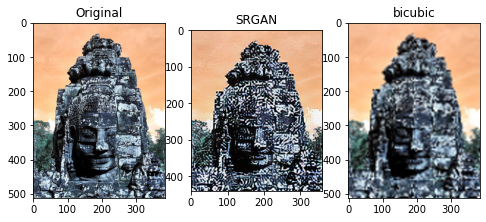

In [53]:
#처리한 데이터를 시각화 할 수 있도록 적용한다.

images=[origin, srgan_from_bicubic, re_origin]
titles=['Original', 'SRGAN', 'bicubic']

plt.figure(figsize=(8,5))
for i, (image, title) in enumerate(zip(images,titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title)

> - 이와 같이, 고화질의 원본 이미지(Original), SRGAN으로 생성한 이미지(SRGAN), bicubic으로 늘린 이미지(bicubic)을 시각화하였다.      

> - 육안으로 봤을 때에는, SRGAN-Original-bicubic 순으로 화질이 좋게 느껴진다.      
> - 좀 더 상세히 살펴보기 위해, 세밀한 부분을 크롭하여 살펴보기로 한다.

In [51]:
#일부 크롭을 위한 함수 세팅
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+x)]

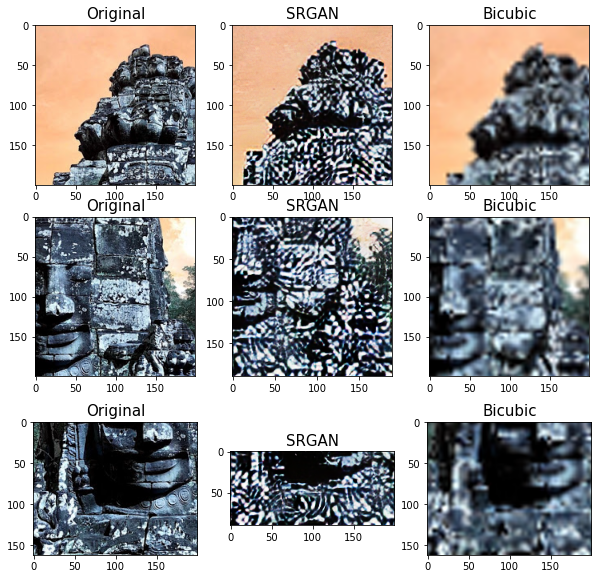

In [55]:
#3개 좌표를 지정하고, 잘라내어 비교해본다.
#이미지 크기인 400*500 선에서 이리저리 크롭해보자.
left_tops=[(10,50), (250,170), (350,50)]

images=[]

for left_top in left_tops:
    image1 = crop(origin, left_top, 200, 200)
    image2 = crop(srgan_from_bicubic, left_top, 200, 200)
    image3 = crop(re_origin, left_top, 200, 200)
    
    images.extend([image1, image2, image3])
    
labels=["Original", "SRGAN", "Bicubic"] * 3

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=15)

> __멀리서 보기에는 SRGAN이 Original보다 더 복원이 잘 된것처럼 보이지만, 실제로는 sharp 효과를 준 것처럼 깨지는 것을 알 수 있다.__    
> 따라서, 실질적인 화질의 차이는 Original-SRGAN-Bicubic(interpolation)으로, 이론적으로 배운 내용과 일치한다.

## 6. Super resolution의 결과 분석하기

1. 결국, 육안으로는 : SRGAN->Original->Interpolation        
2. crop한 이미지로는 : Original->SRGAN->Interpolation 

의 결과를 도출하였다.     

육안으로 SRGAN이 좀 더 선명하게 보이는 것은 이미지 자체에 Sharpeness 효과를 준 것 같이 복원되었기 때문인데,
이에 대해서는 

> 1. 기존에 학습된 SRGAN을 사용했기 때문에, 이번에 투입한 Original 모델의 Soft한 선과는 다소 차이가 있게 복원되었을 수 있다.   
> 2. SRGAN 자체가 이미지의 특징을 추출하여 복원하다 보니, 실제보다 더 날카로운 선을 가지고 복원하였을 수 있다.

라는 가설을 세울 수 있겠다.

실제로, 이것이 동일한 뉘앙스인지는 장담할 수 없지만 [SRGAN논문](https://arxiv.org/pdf/1903.09922.pdf) 에서는 
__" SRGAN fundamentally learns objects, with their shape, color, and texture, and redraws
them in the output rather than attempting to sharpen edges."__  (SRGAN은 기본적으로 물체의 형태, 컬러, 재질로부터 사물을 배운 뒤 더 날카로운(특징적인 이라고도 의역할 수 있겠다) 엣지로 아웃풋을 다시 그린다) __라는 언급이 있기도 하였다.__ 

## 2. 직접 고른 이미지로 SRGAN 실험하기(원래 저해상도)      

- 1의 실험과 달리 원래 작은 크기의 풍경 이미지를 찾아 실험해보자.

### 1. 저해상도 이미지를 찾아 업로드한다.

이미지의 크기 :  (200, 300)


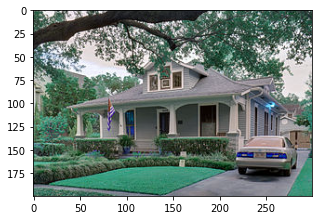

In [63]:
image_file = os.getenv('HOME')+'/SUBMIT_MISSION_GIT/ex16_SRCNN/Image/house.jpg'

low_origin = cv2.imread(image_file)
low_origin_shape = low_origin.shape[:2]

print('이미지의 크기 : ', low_origin_shape)

plt.figure(figsize=(5,8))
plt.imshow(low_origin)

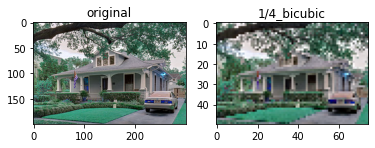

In [65]:
#원래 가로/세로 픽셀은 200*300이므로
bicubic_low_origin = cv2.resize(low_origin, dsize=(75,50), interpolation=cv2.INTER_CUBIC)

images=[low_origin, bicubic_low_origin]
titles=['original', '1/4_bicubic']

for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=12)

### 2. SRGAN에 투입하여 고해상도 이미지를 생성해본다.

Text(0.5, 1.0, 'SRGAN-form bicubic')

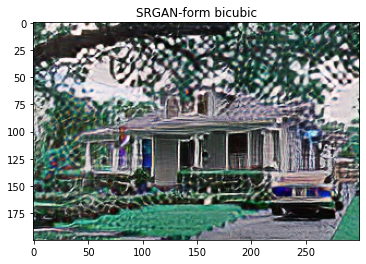

In [69]:
srgan_from_low_bicubic = apply_srgan(bicubic_low_origin)

plt.imshow(srgan_from_bicubic)
plt.title("SRGAN-form bicubic")

### 3. Interpolation을 사용하여 이미지를 생성해본다.

Text(0.5, 1.0, 'interpolation_from_bicubic')

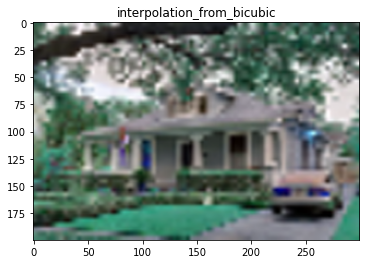

In [73]:
re_low_origin = interpolation_xn(bicubic_low_origin, 4)
re_low_origin = cv2.resize(re_low_origin, dsize=(low_origin.shape[1], low_origin.shape[0]))

plt.imshow(re_low_origin)
plt.title("interpolation_from_bicubic")

### 4. 1(원본), 2(SRGAN), 3(Interpolation)의 이미지를 나란히 시각화한다.

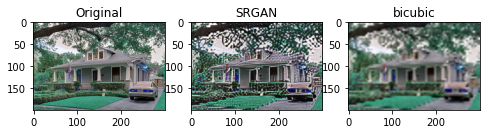

In [74]:
images=[low_origin, srgan_from_low_bicubic, re_low_origin]
titles=['Original', 'SRGAN', 'bicubic']

plt.figure(figsize=(8,5))
for i, (image, title) in enumerate(zip(images,titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title)

> - 1의 시도와 유사한 결과가 나온다. 마찬가지로 크롭하여 확인해보자.

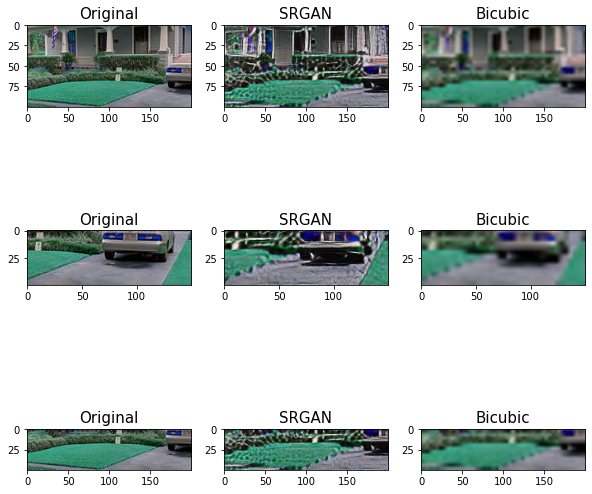

In [77]:
#3개 좌표를 지정하고, 잘라내어 비교해본다.
#이미지 크기인 200*300 선에서 이리저리 크롭해보자.
left_tops=[(100,50), (150,150), (150,50)]

images=[]

for left_top in left_tops:
    image1 = crop(low_origin, left_top, 200, 200)
    image2 = crop(srgan_from_low_bicubic, left_top, 200, 200)
    image3 = crop(re_low_origin, left_top, 200, 200)
    
    images.extend([image1, image2, image3])
    
labels=["Original", "SRGAN", "Bicubic"] * 3

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=15)

### 5. Super Resolution의 결과를 분석하기        

__육안으로 본 화질 차이와 선명도 자체는 1과 유사하지만, 고화질/저화질의 차이가 있다면 저화질에서의 화질 차이가 더 두드러진다는 것이다.__ 

1. 육안으로 본 선명도 : SRGAN - Original - Bicubic         
2. 크롭하여 본 선명도 : Original - SRGAN - Bicubic

이지만, 상대적으로 1(고화질 이미지)를 크롭하여 보았을 때의 선명도 차이보다 2(저화질 이미지)를 크롭하여 보았을 때의 선명도 차이가 더 극명하게 드러난다는 것을 확인할 수 있다.

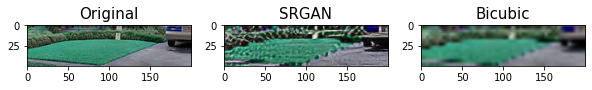

In [81]:
plt.figure(figsize=(10,10))
for i in range(6,9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=15)

![불상크롭](./PostingPic/크롭.png)

> 개인적으로 비교했을 때, 위(저화질)의 화질 차이가 아래(고화질)의 화질 차이보다 두드러져 보인다.   

- 이는 저화질 이미지를 input하기 위해 스케일을 줄이고, 다시 늘리는 과정에서 소실되는 정보의 비율이 더 컸기 때문으로 추측된다.    
- 고화질의 경우, 이미지의 일부가 소실되었다가 복원되더라도 일부가 차지하는 pixel의 영향은 크지 않지만   
- 저화질의 경우, 이미지의 일부가 소실되었다가 복원될 때 '일부 픽셀' 이 가지는 정보가 고화질에 비해 비율적으로 큰 영향을 미칠 수 있기 때문일 것이다.

### 3. SRGAN을 이용해 고해상도 gif 생성하기       

- 시간 관계상 수행하지 못하였음. 추후 업데이트 예정!